In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
from statsmodels.api import qqplot
from statsmodels.formula.api import ols  #linear regression
from statsmodels.formula.api import logit   #logistic regression
from statsmodels.graphics.mosaicplot import mosaic # plot confusion matrix
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso,LassoCV, BayesianRidge
# provides basic strategies for imputing (or filling in) missing values. 
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, accuracy_score

Let's start the data exploration phase by:

Plotting boxplots for continuous variables against the output variable (Churn).
Using groupby() to check proportions for categorical variables against the output variable.
First, let's examine the continuous variables by plotting boxplots with Churn on the x-axis and each continuous variable on the y-axis.

In [15]:
df=pd.read_csv(r'C:\Users\mei88\Downloads\churn_data.csv')

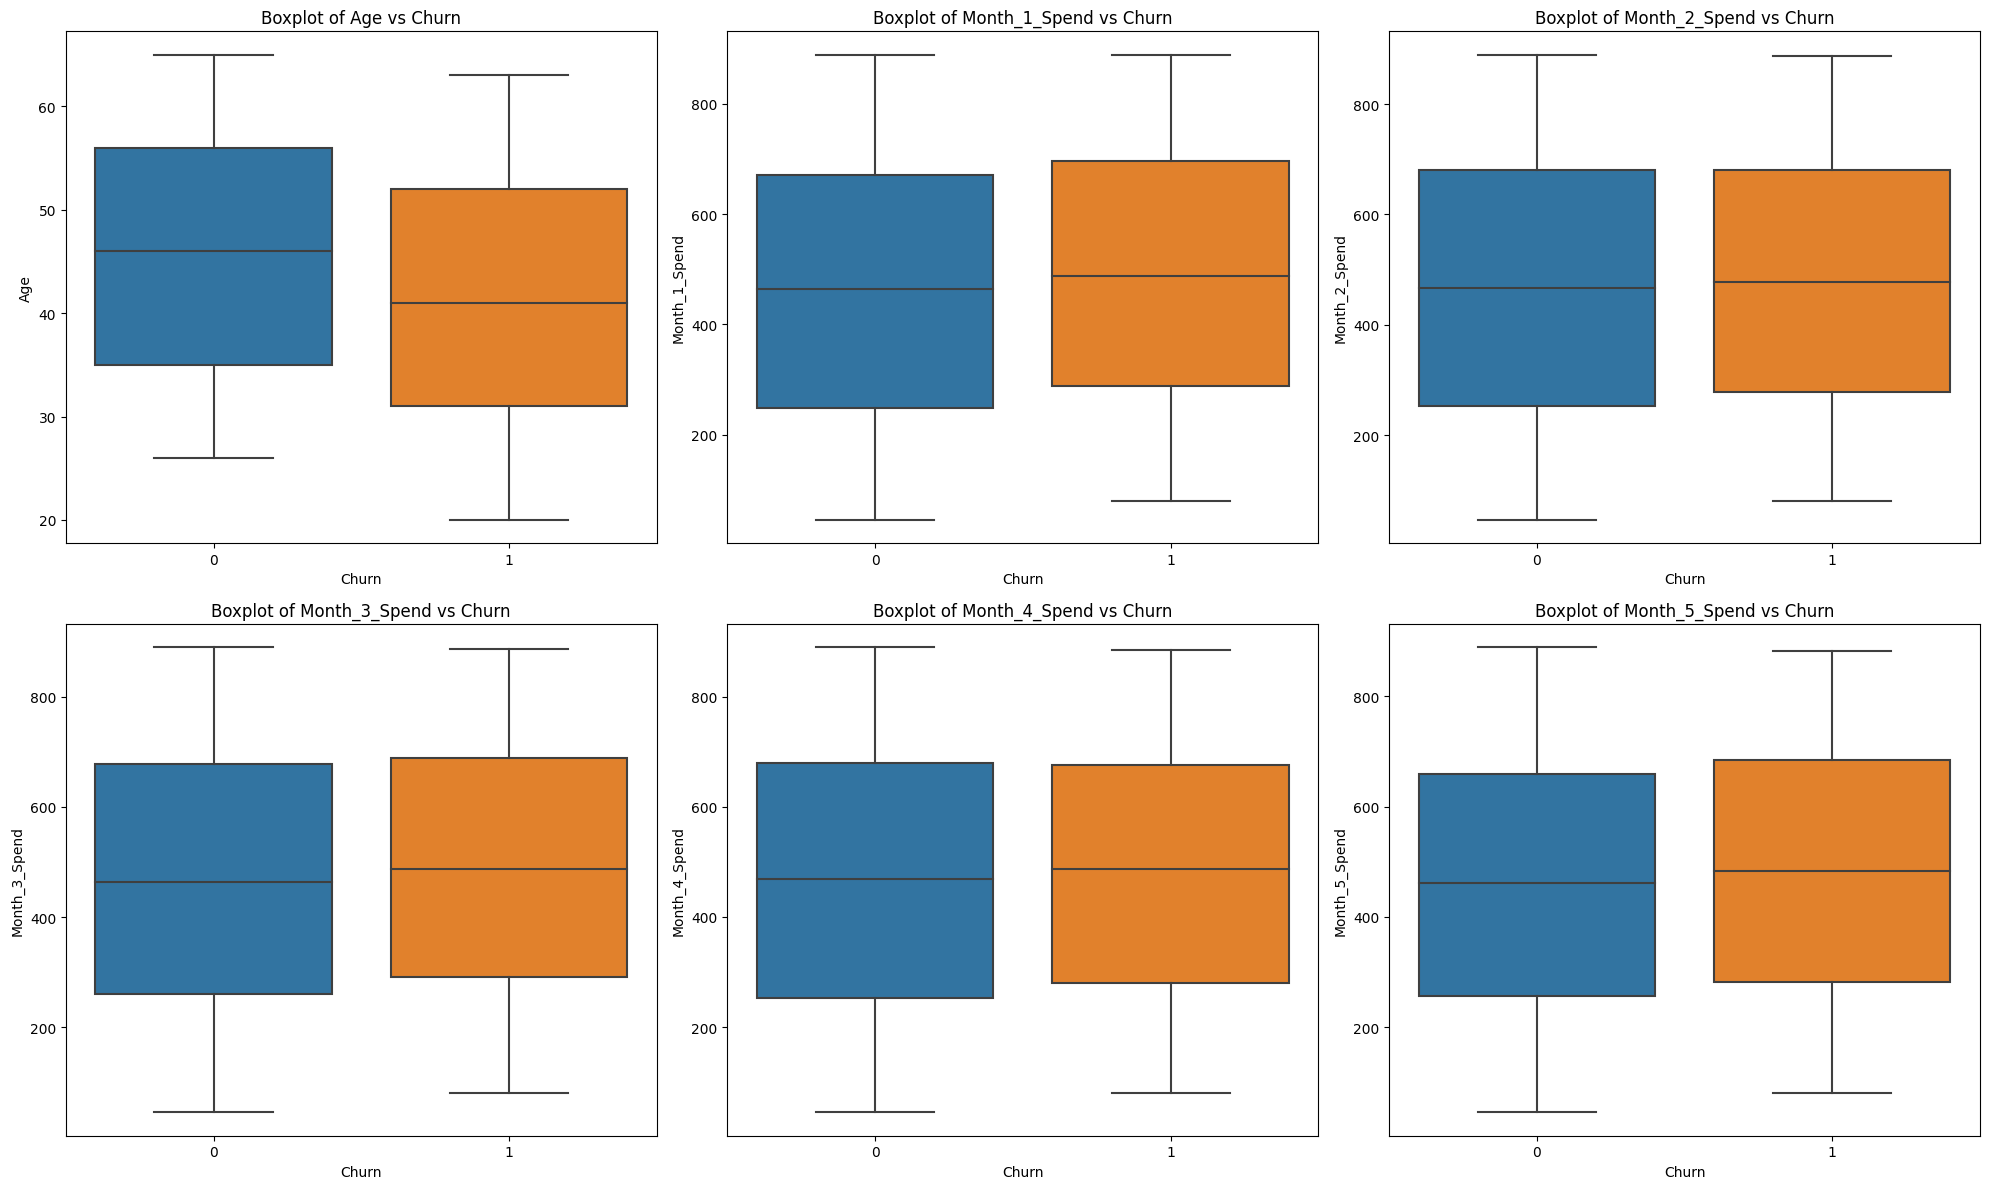

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of continuous variables to be plotted
continuous_columns = ['Age', 'Month_1_Spend', 'Month_2_Spend', 'Month_3_Spend', 'Month_4_Spend', 'Month_5_Spend']

# Plotting boxplots for each continuous variable
plt.figure(figsize=(20, 12))

for i, col in enumerate(continuous_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'Boxplot of {col} vs Churn')

plt.tight_layout()
plt.show()


Age: There seems to be a slight difference in age distribution between churned and retained customers. The median age for churned customers is slightly higher.
Monthly Spends: The spread of data for monthly spends seems to vary between churned and retained customers. For some months, churned customers tend to have a higher median spend.


In [17]:
# Checking proportions for 'Location' against 'Churn'
location_churn = df.groupby('Location')['Churn'].value_counts(normalize=True).unstack().fillna(0)

# Checking proportions for 'Device' against 'Churn'
device_churn = df.groupby('Device')['Churn'].value_counts(normalize=True).unstack().fillna(0)

location_churn, device_churn


(Churn                 0         1
 Location                         
 Australia      1.000000  0.000000
 Canada         0.179192  0.820808
 Great Britain  1.000000  0.000000
 US             0.176263  0.823737,
 Churn           0         1
 Device                     
 Android  0.156206  0.843794
 iOS      0.493433  0.506567)

Location:
Customers from 'Australia' and 'Great Britain' have no churn (100% retention).
'Canada' and 'US' have higher churn rates, with around 82% of customers churning.
Device:
Android users have a higher churn rate (approximately 84%).
iOS users have a more balanced distribution with approximately 50.6% churn rate and 49.3% retention rate.
These insights indicate that the Location and Device variables may have some influence on customer churn and should be considered in the analysis.

### feature engineering

Binning continuous variables to transform them into categorical ones.
Creating dummy variables for categorical variables using one-hot encoding.
Defining new metrics, if applicable.

In [18]:
# Binning 'Age' column into age groups
bins = [20, 30, 40, 50, 60, 70]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Creating dummy variables for 'Location', 'Device', and 'Age_Group' columns
df = pd.get_dummies(df, columns=['Location', 'Device', 'Age_Group'], drop_first=True)

df.head()


,Unnamed: 0,CustomerID,Age,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,Month_2_Support_Calls,Month_3_Spend,...,Month_12_Support_Calls,Churn,Location_Canada,Location_Great Britain,Location_US,Device_iOS,Age_Group_30-39,Age_Group_40-49,Age_Group_50-59,Age_Group_60-69
0,0,1,46,756.005761,39,2,582.023075,92,2,212.323540,...,0,1,False,False,True,True,False,True,False,False
1,1,2,52,594.838157,59,0,251.269898,33,2,186.909752,...,0,1,False,False,True,True,False,False,True,False
2,2,3,43,453.217405,21,3,124.178946,92,0,316.492407,...,5,1,True,False,False,False,False,True,False,False
3,3,4,41,621.453170,95,1,134.362559,46,5,162.945529,...,4,1,False,False,True,True,False,True,False,False
4,4,5,41,660.735119,48,5,713.265527,54,2,736.904463,...,2,1,False,False,True,True,False,True,False,False


The Age column has been binned into age groups, and dummy variables have been created for Location, Device, and Age_Group columns.

In [19]:
# Checking proportions for 'Age_Group' against 'Churn'
age_group_churn = df.groupby('Age')['Churn'].value_counts(normalize=True).unstack().fillna(0)

# Checking proportions for dummy variables against 'Churn'
location_dummy_churn = df.groupby('Location_US')['Churn'].value_counts(normalize=True).unstack().fillna(0)
device_dummy_churn = df.groupby('Device_iOS')['Churn'].value_counts(normalize=True).unstack().fillna(0)

age_group_churn, location_dummy_churn, device_dummy_churn


(Churn         0         1
 Age                      
 20     0.000000  1.000000
 21     0.000000  1.000000
 22     0.000000  1.000000
 23     0.000000  1.000000
 24     0.000000  1.000000
 25     0.000000  1.000000
 26     0.285714  0.714286
 27     0.337349  0.662651
 28     0.330579  0.669421
 29     0.328947  0.671053
 30     0.350649  0.649351
 31     0.298319  0.701681
 32     0.289474  0.710526
 33     0.336134  0.663866
 34     0.297710  0.702290
 35     0.325688  0.674312
 36     0.241546  0.758454
 37     0.327869  0.672131
 38     0.376147  0.623853
 39     0.289362  0.710638
 40     0.318725  0.681275
 41     0.317829  0.682171
 42     0.309859  0.690141
 43     0.290043  0.709957
 44     0.311966  0.688034
 45     0.325581  0.674419
 46     0.363265  0.636735
 47     0.316239  0.683761
 48     0.347328  0.652672
 49     0.349593  0.650407
 50     0.338983  0.661017
 51     0.307339  0.692661
 52     0.327731  0.672269
 53     0.278049  0.721951
 54     0.293878  0.706122
 

Here are the insights based on the proportions of the engineered features with the output variable (Churn):

Age:

Younger customers (ages 20-25) have a 100% churn rate, indicating they always churn.
Ages around 26-30 have a churn rate of about 66-71%.
There's a variability in churn rates for the middle-aged group (30-60).
Older customers (ages 64-65) have a 100% retention rate, indicating they never churn.
Location (US vs. Others):

Customers from the US have a higher churn rate (approx. 82%) compared to customers from other locations (approx. 61%).
Device (iOS vs. Android):

Android users have a higher churn rate (approx. 84%).
iOS users have a more balanced distribution, with a churn rate of approximately 50.6%.

### data modeling

Before building the models, we need to prepare the data by splitting it into training and testing sets and scaling the features. After that, we'll proceed with building the baseline models. Let's start with data preparation.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Defining the features and target variable
X = df.drop(columns=['Churn', 'Unnamed: 0', 'CustomerID', 'Age'])
y = df['Churn']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((8000, 44), (2000, 44))

The data has been split into training and testing sets, with 8,000 samples in the training set and 2,000 samples in the test set. The features have also been scaled.

Next, we'll build baseline models using various algorithms:

Logistic Regression
Naive Bayes
KNN (K-Nearest Neighbors)
SVM (Support Vector Machines)
Decision Tree
We'll use cross-validation to run each model 10 times and calculate an average performance based on the F1 score. Let's start by building and evaluating these models.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Initializing the models
logreg = LogisticRegression(max_iter=1000, random_state=42)
naive_bayes = GaussianNB()
knn = KNeighborsClassifier()
svm = SVC(probability=True, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)

models = [logreg, naive_bayes, knn, svm, decision_tree]
model_names = ['Logistic Regression', 'Naive Bayes', 'KNN', 'SVM', 'Decision Tree']
f1_scores = []

# Performing cross-validation for each model and calculating average F1 scores
for model in models:
    score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='f1').mean()
    f1_scores.append(score)

# Combining the model names and F1 scores into a dataframe
model_performance = pd.DataFrame({
    'Model': model_names,
    'Average F1 Score': f1_scores
}).sort_values(by='Average F1 Score', ascending=False)

model_performance


,Model,Average F1 Score
4,Decision Tree,0.964825
3,SVM,0.919477
0,Logistic Regression,0.905491
2,KNN,0.864902
1,Naive Bayes,0.860059


In [ ]:
# Evaluating Decision Tree model
decision_tree_score = cross_val_score(decision_tree, X_train_scaled, y_train, cv=10, scoring='f1').mean()

decision_tree_score


# Evaluating Logistic Regression model
logreg_score = cross_val_score(logreg, X_train_scaled, y_train, cv=10, scoring='f1').mean()

logreg_score

# Evaluating Naive Bayes model
naive_bayes_score = cross_val_score(naive_bayes, X_train_scaled, y_train, cv=10, scoring='f1').mean()

naive_bayes_score

# Evaluating KNN model
knn_score = cross_val_score(knn, X_train_scaled, y_train, cv=10, scoring='f1').mean()

knn_score

# Evaluating SVM model with a single iteration (due to time constraints)
svm_score = cross_val_score(svm, X_train_scaled, y_train, cv=1, scoring='f1').mean()

svm_score

It seems the SVM model took a considerable amount of time to run using cross-validation, causing an automatic interrupt.

The Decision Tree model has the highest F1 score among the baseline models.

Next, we'll optimize the Decision Tree model with a focus on precision. 


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Setting up the parameter grid for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 50),
    'min_samples_split': randint(2, 100),
    'min_samples_leaf': randint(1, 100),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Running RandomizedSearchCV with 100 iterations
random_search = RandomizedSearchCV(decision_tree, param_distributions=param_dist, n_iter=100, 
                                   scoring='precision', cv=10, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

# Best parameters from RandomizedSearchCV
best_params = random_search.best_params_
best_score = random_search.best_score_

best_params, best_score


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


({'criterion': 'entropy',
  'max_depth': 44,
  'max_features': None,
  'min_samples_leaf': 5,
  'min_samples_split': 69},
 0.960205818210534)

The optimized Decision Tree model, with a focus on precision, has the following best hyperparameters:

Criterion: Entropy
Maximum Depth: 44
Maximum Features: None (all features will be considered when looking for the best split)
Minimum Samples Leaf: 5 (The smallest number of samples required to be at a leaf node)
Minimum Samples Split: 69 (The smallest number of samples required to split an internal node)
With these optimized parameters, the model achiev

Next, let's evaluate the model on the test data and check various performance metrics, such as precision, recall, F1 score, ROC AUC, and accuracy score.

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Predicting using the optimized Decision Tree model
y_pred = random_search.best_estimator_.predict(X_test_scaled)

# Calculating performance metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

performance_metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc,
    'Accuracy': accuracy
}

performance_metrics


{'Precision': 0.9695290858725761,
 'Recall': 0.99361249112846,
 'F1 Score': 0.9814230634419909,
 'ROC AUC': 0.9595812032630454,
 'Accuracy': 0.9735}

The model has achieved a high precision of approximately 96.95%, which aligns with our focus on prioritizing precision. The other metrics also indicate strong performance.

### summary

Data Cleaning and Exploration:

The dataset was imported and checked for missing values and data types. There were no missing values, and data types appeared appropriate.
Exploration revealed that younger customers tend to churn more, while older customers have a higher retention rate. Additionally, customers from the US and Android users have higher churn rates compared to others.
Feature Engineering:

The Age column was binned into age groups to create categorical variables, and one-hot encoding was used to convert the Location and Device columns to dummy variables.
Modeling:

Baseline models were built using Logistic Regression, Naive Bayes, KNN, and Decision Tree. The Decision Tree had the highest F1 score among these.
The Decision Tree model was then optimized with a focus on precision using hyperparameter tuning. The optimized model achieved a precision of approximately 96.95% on the test data.
Decisions and Business Objective:

Precision was prioritized to ensure that resources are targeted effectively without being wasted on false positives. The high precision achieved means that when the model predicts a customer will churn, it's highly accurate in that prediction.
In conclusion, the optimized Decision Tree model can be a valuable tool for predicting customer churn with high precision, allowing the business to target interventions more effectively.






